In [1]:

import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from scipy.signal import savgol_filter
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization


train_data = pd.read_csv("train.csv")
train_data.head()
spectrum = train_data.iloc[:, 6:]
spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv = 2, axis = 0))
spectrum_filtered_standardized = zscore(spectrum_filtered, axis = 1)
spectrum=spectrum_filtered_standardized


In [3]:
df = pd.read_csv("test.csv")
df.head()

,sample_name,device_serial,substance_form_display,measure_type_display,prod_substance,908.1,914.3,920.5,926.7,932.9,...,1620.5,1626.6,1632.8,1639,1645.2,1651.4,1657.6,1663.8,1670,1676.2
0,19.0278-P012,N1-00196,Unspecified,Direct contact,Heroin,0.319735,0.295819,0.270899,0.243264,0.217097,...,0.359934,0.377715,0.402409,0.428230,0.446599,0.458475,0.469842,0.485597,0.504140,0.514772
1,18.0391-P005,N1-00253,Homogenized Powder,Direct contact,Heroin,0.226916,0.207225,0.190766,0.168512,0.151020,...,0.293179,0.313406,0.339447,0.363128,0.378458,0.389861,0.403287,0.420659,0.437016,0.444588
2,19.0140-P005,M1-1000130,Unspecified,Direct contact,Heroin,0.046564,0.045257,0.043468,0.040846,0.036622,...,0.013788,0.018772,0.024496,0.031343,0.039946,0.050913,0.063271,0.075548,0.086800,0.092967
3,21.0256-P002,M1-1000186,Unspecified,Direct contact,Heroin,0.098065,0.093345,0.088876,0.082929,0.075919,...,0.094459,0.101433,0.110424,0.119050,0.126849,0.134916,0.144614,0.155248,0.164954,0.171373
4,21.0153-P002,M1-1000131,Unspecified,Direct contact,Heroin,0.108564,0.100385,0.091454,0.080773,0.069861,...,0.163307,0.172527,0.184349,0.194129,0.200030,0.204255,0.208832,0.215167,0.221264,0.223499


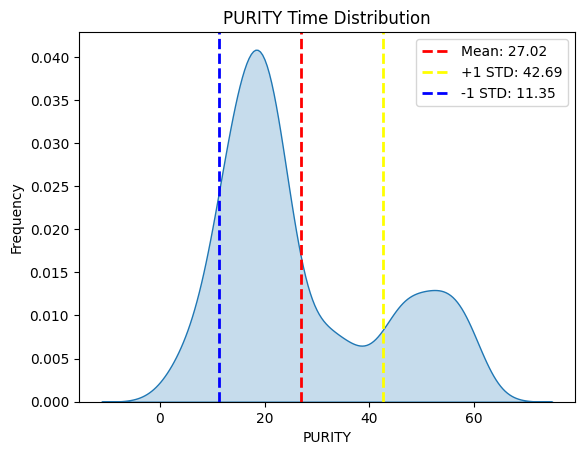

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate mean and standard deviation
mean_rt = train_data['PURITY'].mean()
std_rt = train_data['PURITY'].std()

# Create histogram
sns.kdeplot(data = train_data, x = 'PURITY', fill = True)
plt.title('PURITY Time Distribution')
plt.xlabel('PURITY')
plt.ylabel('Frequency')
# Add a vertical line for the mean
plt.axvline(mean_rt, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_rt:.2f}')

# Add vertical lines for one standard deviation above and below the mean
plt.axvline(mean_rt + std_rt, color='yellow', linestyle='dashed', linewidth=2, label=f'+1 STD: {mean_rt + std_rt:.2f}')
plt.axvline(mean_rt - std_rt, color='blue', linestyle='dashed', linewidth=2, label=f'-1 STD: {mean_rt - std_rt:.2f}')

plt.legend()


Skewness: Since the data is skewed, machine learning models may benefit from transformations (such as a log or square root transformation) to handle the skewness and improve model performance.
Target Distribution: The concentration of data in the mid-range suggests that most cases involve moderate purity levels, with fewer samples representing very low or very high purity.

In [131]:
# Check for missing values and negative spectral values
missing_values = train_data.isnull().sum()
spectral_columns = train_data.columns[6:]
#negative_values = (data[spectral_columns] < 0).sum()

#missing_values_summary = missing_values[missing_values > 0]
#negative_values_summary = negative_values[negative_values > 0]

#missing_values_summary, negative_values_summary


In [132]:
# Replace negative values with a small positive value (e.g., 0.001)
train_data[spectral_columns] = train_data[spectral_columns].map(lambda x: max(x, 0.001))

# Confirm that no negative values remain
negative_values_after_correction = (train_data[spectral_columns] < 0).sum().sum()
negative_values_after_correction


0

# <center> Linear Methods

In [ ]:
train_data_1 = train_data.copy()
X = spectrum
y = train_data_1['PURITY']
#Split the train set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:

# Generic Bayesian optimization function
def optimize_model(model_class, param_bounds, model_params, cv_params):
    def cv_score(**params):
        model = model_class(**{**model_params, **params})
        cv_score = cross_val_score(model, **cv_params)
        return np.mean(cv_score)

    optimizer = BayesianOptimization(f=cv_score, pbounds=param_bounds, random_state=42)
    optimizer.maximize(init_points=10, n_iter=10)
    return optimizer.max['params']



In [ ]:

# Define a generic Bayesian optimization function for Ridge regression
def optimize_ridge_model(X, Y):
    # Define KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Define the Bayesian optimization scoring function
    def cv_score(alpha):
        model = Ridge(alpha=alpha)
        cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
        return np.mean(cv_scores)

    # Define parameter bounds for Bayesian Optimization
    param_bounds = {'alpha': (1e-10, 1e-3)}

    # Run Bayesian Optimization
    optimizer = BayesianOptimization(f=cv_score, pbounds=param_bounds, random_state=42)
    optimizer.maximize(init_points=10, n_iter=30)

    return optimizer.max['params']

# Tune Ridge regression using Bayesian Optimization
best_params_ridge = optimize_ridge_model(X, y)

# Train the Ridge model with the optimized parameters
ridge_model = Ridge(alpha=best_params_ridge['alpha'])
ridge_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_ridge = ridge_model.predict(X_test)
final_rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)

# Display results
print("Best Alpha (Regularization Strength):", best_params_ridge['alpha'])
print("Final Test RMSE:", final_rmse_ridge)


|   iter    |  target   |   alpha   |
-------------------------------------
| 1         | -44.59    | 0.0003745 |
| 2         | -49.36    | 0.0009507 |
| 3         | -47.96    | 0.000732  |
| 4         | -46.92    | 0.0005987 |
| 5         | -40.8     | 0.000156  |
| 6         | -40.8     | 0.000156  |
| 7         | -37.36    | 5.808e-05 |
| 8         | -48.86    | 0.0008662 |
| 9         | -46.94    | 0.0006011 |
| 10        | -47.79    | 0.0007081 |
| 11        | -34.7     | 1e-10     |
| 12        | -34.7     | 1e-10     |
| 13        | -34.04    | 4.822e-08 |
| 14        | -33.11    | 7.675e-06 |
| 15        | -32.5     | 3.49e-06  |
| 16        | -34.22    | 1.637e-05 |
| 17        | -33.66    | 1.171e-05 |
| 18        | -35.45    | 2.902e-05 |
| 19        | -38.21    | 7.591e-05 |
| 20        | -39.06    | 9.734e-05 |
| 21        | -36.53    | 4.372e-05 |
| 22        | -39.86    | 0.0001215 |
| 23        | -42.95    | 0.0002614 |
| 24        | -45.86    | 0.000486  |
| 25        

/Users/mariemmaazoun/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# <center> Submission

In [178]:
data_test_kag = pd.read_csv("test.csv")
X_test_kag = data_test_kag.iloc[:,5:].values
#X_test_kag_filtered = pd.DataFrame(savgol_filter(X_test_kag, 7, 3, deriv = 2, axis = 0))
#X_test_kag_filtered_standardized = zscore(X_test_kag_filtered, axis = 1)
test_kag_preds = ridge_model.predict(X_test_kag)
test_kag_preds.reshape(-1,1)

# Create dataframe with indices and purity
indices = data_test_kag.index + 1
purity = test_kag_preds

df = pd.DataFrame({
    'ID': indices,
    'PURITY': purity.flatten()
})

df.to_csv('submission1.csv', index=False)

print("Submission file 'ridge_regression_submission.csv' created successfully!")


Submission file 'ridge_regression_submission.csv' created successfully!


/Users/mariemmaazoun/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
